# Version multidimensionnelle (Piterbarg 2 p.575)


On pose $$\chi(t) = - \frac{\mathrm{d}H(t)}{\mathrm{d}t} H(t)^{-1}$$ Et $H(t) = diag(h(t)) = diag\big( (h_1(t),...,h_d(t) )\big)$

Donc $$\chi(t) = \begin{pmatrix} -h_1'(t) & 0 \\ ... & ... \\ 0 .. & -h_d'(t)\end{pmatrix} \begin{pmatrix} h_1(t) & 0 \\ ... & ... \\ 0 .. & h_d(t)\end{pmatrix}^{-1} \\
\iff \chi(t) = \begin{pmatrix} - \frac{h_i'(t)}{h_i(t)} \mathbb{1}_{i=j} \end{pmatrix}$$

Donc $$\forall i=1,d, \quad h_i(t) = e^{-\chi_i t}$$

Avec cela, $$H(t) H^f(t)^{-1} = \big(H^f(t) H(t)^{-1} \big)^{-1} = \Big( \begin{bmatrix}e^{-\chi_1 (t+\delta_1)} & ... & e^{-\chi_d (t+\delta_1)} \\ & ... & \\ e^{-\chi_1 (t+\delta_d)} & ... & e^{-\chi_d (t+\delta_d)}\end{bmatrix} \begin{bmatrix}e^{- \chi_1 t} & ... &  0 \\ 0 & ... & 0 \\ 0 & ... & e^{- \chi_d t} \end{bmatrix}^{-1}\Big)^{-1} \\
= \begin{bmatrix} e^{\chi_1 t}e^{-\chi_1 (t+\delta_1)} & ... & e^{\chi_d t} e^{-chi_d (t+\delta_1)} \\
 & ... & \\
e^{\chi_1 t}e^{-\chi_1 (t+\delta_d)} & ... & e^{\chi_d t}e^{-\chi_d (t+\delta_d)} \end{bmatrix}^{-1} \\
= \begin{bmatrix} e^{-\chi_1 \delta_1} & ... & e^{-\chi_d \delta_1} \\
 & ... & \\
e^{-\chi_1 \delta_d} & ... & e^{-\chi_d \delta_d} \end{bmatrix}^{-1}$$

Enfin on pose la volatilité locale: $$\sigma_r(t,x(t),y(t))^\top = H(t) H^f(t)^{-1} \begin{pmatrix} \lambda_1(a_1 + b_1 f_1(t)) & 0 & 0.. \\ 0 & \lambda_2(a_2 + b_2 f_2(t)) & 0 ..\\ 0 & .. & \lambda_d(a_d + b_d f_d(t))\end{pmatrix} \ D^f(t)^\top \\
= \tilde{H}(t) \ \sigma^f(t,f(t)) \ D^f(t)^\top$$

Où $D^f(t)^\top$ est telle que $$\Gamma = D^f(t)^\top D^f(t)$$ avec $\Gamma$ la matrice de corrélation des taux $f_i(t)$.

Enfin, $$\forall i =1,d, \quad f_i(t) = f(t,t + \delta_i) = f(0,t+\delta_i) + \mathbf{1}^\top H(t+ \delta_i) H(t)^{-1} \big(x(t) + y(t) \ G(t,t+\delta_i)\big)$$

$$G(t,T) = \int_{t}^{T} H(u) H(t)^{-1} \mathbf{1} \ \mathrm{d}u \\
= \begin{bmatrix} \frac{1 - e^{- \chi_1(T-t)}}{\chi_1} \\ ... \\ \frac{1 - e^{- \chi_d(T-t)}}{\chi_d} \end{bmatrix}$$

In [1]:
import numpy as np
import math
from time import time
import matplotlib.pyplot as plt
from random import *
import scipy.integrate as integrate
np.random.seed(10)

def vecteur_uni(d):
    return np.transpose(np.ones(d))

def diag(v):
    n = len(v)
    mat = np.zeros((n,n))
    for i in range(n):
        mat[i][i] = v[i]
    return mat

In [2]:
#return cholesky decomposition D of the correlation matrix
def D(corr_mat):
    return np.linalg.cholesky(corr_mat)

def H(t,chi,d):
    v = [np.exp(-chi[i]*t) for i in range(d)]
    return diag(v)

def H_tilde(chi,delta,d):
    resu = np.zeros((d,d))
    for i in range(d):
        for j in range(d):
            resu[i][j] = np.exp(-chi[j] * delta[i])
    return resu

def G(t,T,chi,d):
    resu = np.zeros(d)
    for i in range(d):
        resu[i] = (1-np.exp(-chi[i]*(T-t)))/chi[i]
    return np.transpose(resu)
    
    
# Return the forward rates f1(t),f2(t)... fd(t) 
#init_forward : vector f(0,t+delta1),... f(0,t+deltad)

def f(t,chi,delta,d,init_forward,x,y):
    resu = np.zeros(d)
    Gt = np.array([G(t,t+delta[i],chi,d) for i in range(d)])
    for i in range(d):
        vect1 = np.array([np.exp(-chi[j]*delta[i]) for j in range(d)])
        vect2 = x + y.dot(Gt[i])
        resu[i] = init_forward[i] + vect1.dot(vect2)
    return resu

$$r(t) = f(0,t) + \mathbb{1}^\top x(t) \\ \implies e^{- \int_{0}^{T_0} r(s) \ \mathrm{d}s} = P(0,T_0) \ e^{- \sum_{i=1}^d \int_{0}^{T_0} x^{(i)}(s) \ \mathrm{d}s} = P(0,T_0) \ e^{\sum_{i=1}^d I_i(T_0)}$$

Simulation des trajectoires de $x,y,I$ en dimension $d$.
La fonction renvoit M triplets du type $$\begin{bmatrix} x_1(T_0) & ... & x_d(T_0) \end{bmatrix} ,  
\begin{bmatrix} y_{1,1}(T_0) & ... & y_{1,d}(T_0) \\
... \\
y_{d,1}(T_0) & ... & y_{d,d}(T_0) \end{bmatrix} , 
\begin{bmatrix} I_1(T_0) & ... & I_d(T_0)\end{bmatrix}$$


In [3]:
#Limite supérieure et inférieure des diffusions de x_1,...,x_d : limiter artificiellement les elements à 1e10 pour éviter les explosions

def lim_diffx(d,x,a,b):
    for i in range(d):
        if(x[i]>1e10):
            x[i] = 1e10
        elif(x[i] < -a[i]/b[i]):
            x[i] = -a[i]/b[i]
    return x

def lim_diffy(d,y):
    for i in range(d):
        for j in range(d):
            if(y[i][j] > 1e10):
                y[i][j] = 1e10
    return y

#Simulation du schéma discret

def simul_multi(M,N,T0,d,chi,delta,init_forward,corr_mat,lmbda,a,b):
    dt = T0/N
    resu_x = np.zeros((M,d))
    resu_y = np.zeros((M,d,d))
    resu_I = np.zeros((M,d))
    v_uni = vecteur_uni(d)
    chi_mat = diag(chi)
    Df = D(corr_mat) #matrice de corrélation constante
    
    for m in range(M):
        I = np.zeros(d)
        x = np.zeros(d)
        y = np.zeros((d,d))
        Z = np.random.standard_normal(N*d)
        
        for i in range(N):
            t = i * dt
            
            #construction de sigma
            H_tild = H_tilde(chi,delta,d)
            ft = f(t,chi,delta,d,init_forward,x,y)
            diag_sigmaf = [lmbda[k] * (a[k] + b[k]*ft[k]) for k in range(d)]
            sigma_f = diag(diag_sigmaf) 
            sigma_i = H_tild.dot(sigma_f.dot(np.transpose(Df)))
            
            # incrément brownien
            incr = math.sqrt(dt)*np.array([Z[i*d+j] for j in range(d)])

            I = I - x * dt
            
            x = x + (y.dot(v_uni) - chi_mat.dot(x)) * dt + sigma_i.dot(incr)
            x = lim_diffx(d,x,a,b) #On prend gare à l'explosion d'un terme dans x
            
            y = y + (sigma_i.dot(np.transpose(sigma_i)) - chi_mat.dot(y) - y.dot(chi_mat)) * dt
        resu_I[m] = I
        resu_x[m] = x
        resu_y[m] = y
    return resu_I,resu_x,resu_y

### Log Euler

Dim 1: $$x(t) = e^{u(t)} - \frac{a}{b}$$

Dim d: $$x(t) = \Big[ e^{u^{(i)}(t)} - \frac{a^{(i)}}{b^{(i)}}\Big]_{i=1,d}$$

Or $\forall i, \quad \mathrm{d}x^{(i)}(t) = \Big( y^{(i)}(t) \mathbb{1} - \chi_i x^{(i)} \Big) \ \mathrm{d}t + \sum_{j=1}^d \sigma_r^{(i,j)} \ \mathrm{d}W_t^{(j)}$

Donc $$\begin{array}{ll} \forall i, \quad \mathrm{d}u^{(i)}(t) &= \frac{1}{x^{(i)}(t) + \frac{a^{(i)}}{b^{(i)}}} \Big(  y^{(i)}(t) \mathbb{1} - \chi_i x^{(i)} - \frac{1}{2} \frac{1}{x^{(i)}(t) + \frac{a^{(i)}}{b^{(i)}}} \sum_{k,j=1}^d \sigma_r^{(i,k)} \sigma_r^{(i,j)} \rho_{k,j} \Big) \ \mathrm{d}t + \frac{1}{x^{(i)}(t) + \frac{a^{(i)}}{b^{(i)}}} \sigma_r^{(i)} \ \mathrm{d}W_t \\
\text{Ici } \rho_{k,j} = \mathbb{1}_{k=j} \\
&= \frac{1}{x^{(i)}(t) + \frac{a^{(i)}}{b^{(i)}}} \Big(  y^{(i)}(t) \mathbb{1} - \chi_i x^{(i)} - \frac{1}{2} \frac{1}{x^{(i)}(t) + \frac{a^{(i)}}{b^{(i)}}} \sigma_r^{(i)} (\sigma_r^{(i)})^\top \Big) \ \mathrm{d}t + \frac{1}{x^{(i)}(t) + \frac{a^{(i)}}{b^{(i)}}} \sigma_r^{(i)} \ \mathrm{d}W_t
\end{array}$$

In [4]:
def log_Euler(M,N,T0,d,chi,delta,init_forward,corr_mat,lmbda,a,b):
    dt = T0/N
    resu_x = np.zeros((M,d))
    resu_y = np.zeros((M,d,d))
    resu_I = np.zeros((M,d))
    v_uni = vecteur_uni(d)
    chi_mat = diag(chi)
    Df = D(corr_mat) #matrice de corrélation constante
    
    for m in range(M):
        I = np.zeros(d)
        x = np.zeros(d)
        u = np.array([np.log(a[i]/b[i]) for i in range(d)])
        y = np.zeros((d,d))
        Z = np.random.standard_normal(N*d)
        
        for n in range(N):
            t = n * dt
            
            #construction de sigma
            H_tild = H_tilde(chi,delta,d)
            ft = f(t,chi,delta,d,init_forward,x,y)
            diag_sigmaf = [lmbda[k] * (a[k] + b[k]*ft[k]) for k in range(d)]
            sigma_f = diag(diag_sigmaf) 
            sigma_n = H_tild.dot(sigma_f.dot(np.transpose(Df)))

            # incrément brownien
            incr = math.sqrt(dt)*np.array([Z[n*d+j] for j in range(d)])

            I = I - x * dt
            for i in range(d):
                temp = 1/(x[i] + a[i]/b[i])
                saut = temp * (y[i].dot(v_uni) - chi[i]*x[i] - 0.5 * temp * sigma_n[i].dot(np.transpose(sigma_n[i]))) * dt + temp * sigma_n[i].dot(incr)
                sign = -1 + 2*(u[i] + saut>0)
                if(np.absolute(u[i] + saut) > 1e10):
                    u[i] = sign * 1e10
                else:
                    u[i] = u[i] + saut
                
                exp_u = np.exp(u[i])
                if(exp_u < 1e-16):
                    exp_u = 1e-16  #Borné à 1e-16 car si plus petit, exp_u - ai/bi = ai/bi et division par zero
                x[i] = exp_u - a[i]/b[i]

            y = lim_diffy(d,y + (sigma_n.dot(np.transpose(sigma_n)) - chi_mat.dot(y) - y.dot(chi_mat)) * dt)

        resu_I[m] = I
        resu_x[m] = x
        resu_y[m] = y
    return resu_I,resu_x,resu_y

In [5]:
def payoff_swaption_multi(d,maturities,bonds,x,y,chi,K):
    T0 = maturities[0]                             #maturities = [T0,...,TN]
    nb_maturities = len(maturities)
    A = 0
    #calculate the annuity A
    for n in range(nb_maturities-1):
        g = G(T0,maturities[n+1],chi,d)
        A += (maturities[n+1]-maturities[n])*bonds[n+1]*np.exp(-1*g.dot(x)-0.5*g.dot(y.dot(g)))
    g = G(T0,maturities[-1],chi,d)
    swap = bonds[0] - bonds[-1]*np.exp(-1*g.dot(x)-0.5*g.dot(y.dot(g))) - K*A
    if swap>0:
        return swap
    else:
        return 0

In [6]:
def swaption_MC_multi(d,M,sim,K,chi,bonds,maturities,exec_time=False,variance = False):
    t1 = time()
    Monte_Carlo = 0
    moment_2 = 0
    I,X,Y = sim
    nb_occ_suppr = 0 #nombre occurences supprimées
    for m in range(M):
        int_x = I[m]
        x = X[m]
        y = Y[m]
        if(np.isnan(np.sum(int_x)) or np.isnan(np.sum(x)) or np.isnan(np.sum(y))):
            nb_occ_suppr += 1
        else:
            s_m = np.exp(sum(int_x))*payoff_swaption_multi(d,maturities,bonds,x,y,chi,K)
            Monte_Carlo += s_m
            moment_2 += s_m**2
    t2 = time()
    price = Monte_Carlo/(M - nb_occ_suppr)
    if(exec_time):
        print("Execution time: ",t2-t1, "sec")
    if(variance):
        var = moment_2/(M- nb_occ_suppr) - price**2
        print("Variance:",var)
    print("Nb. Occurences Supprimées:",nb_occ_suppr)
    return price

In [7]:
#Annuity
def A(t,x,y,maturities,bonds,ZC_t,chi,d):
    nb_maturities = len(maturities)
    resu = 0
    for n in range(nb_maturities-1):
        g = G(t,maturities[n+1],chi,d)
        resu += (maturities[n+1]-maturities[n])*(bonds[n+1]/ZC_t)*np.exp(-1*np.transpose(g).dot(x)-0.5*np.transpose(g).dot(y.dot(g)))
    return resu

# Swap rate in the model
def S(t,x,y,maturities,bonds,ZC_t,chi,d):
    if (t==0):
        return (bonds[0]-bonds[-1])/A(t,x,y,maturities,bonds,ZC_t,chi,d)
    else:
        g0 = G(t,maturities[0],chi,d)
        gN = G(t,maturities[-1],chi,d)
        PT0 = bonds[0]*np.exp(-1*np.transpose(g0).dot(x)-0.5*np.transpose(g0).dot(y.dot(g0)))
        PTN = bonds[-1]*np.exp(-1*np.transpose(gN).dot(x)-0.5*np.transpose(gN).dot(y.dot(gN)))
        return (PT0-PTN)/A(t,x,y,maturities,bonds,ZC_t,chi)

## Tests

In [14]:
d = 2
chi = [0.015,0.15]
delta = [0.5,2]
M = 100000
N = 250
T0 = 0.5
init_forward = [0.05,0.05]
corr_mat = np.eye(d)
a = [1,1]
b = [1,1]
lmbda = [1,1]
K = 0.05
maturities = np.arange(T0,T0+5.5,0.5)
bonds = [np.exp(-0.05*m) for m in maturities]

print("H_tilde=",np.linalg.inv(H_tilde(chi,delta,d)))

#print(G(0,1,chi,1))

H_tilde= [[-4.48867421  5.62126868]
 [ 5.88000365 -6.01380333]]


i= 0
sigma_f= [[1.05 0.  ]
 [0.   1.05]]
H_tilde= [[0.99252805 0.92774349]
 [0.97044553 0.74081822]]
x= [0.0643268  0.06400699] y= [[0.00407003 0.00363932]
 [0.00363932 0.00328672]]

i= 1
sigma_f= [[1.18013119 0.        ]
 [0.         1.18324704]]
H_tilde= [[0.99252805 0.92774349]
 [0.97044553 0.74081822]]
x= [0.11474612 0.10294253] y= [[0.00922385 0.00824553]
 [0.00824553 0.00744471]]

i= 2
sigma_f= [[1.27503325 0.        ]
 [0.         1.29064437]]
H_tilde= [[0.99252805 0.92774349]
 [0.97044553 0.74081822]]
x= [0.21836997 0.19767135] y= [[0.01529378 0.01366428]
 [0.01366428 0.0123307 ]]

i= 3
sigma_f= [[1.47604642 0.        ]
 [0.         1.4962385 ]]
H_tilde= [[0.99252805 0.92774349]
 [0.97044553 0.74081822]]
x= [0.17180875 0.14617401] y= [[0.0234392  0.02093413]
 [0.02093413 0.01888425]]

i= 4
sigma_f= [[1.3958482 0.       ]
 [0.        1.4596681]]
H_tilde= [[0.99252805 0.92774349]
 [0.97044553 0.74081822]]
x= [0.20235936 0.17326369] y= [[0.03094426 0.0276093 ]
 [0.0276093  0.02488

sigma_f= [[1.88155842e+10 0.00000000e+00]
 [0.00000000e+00 6.32855505e+10]]
H_tilde= [[0.99252805 0.92774349]
 [0.97044553 0.74081822]]
x= [-1. -1.] y= [[1.e+10 1.e+10]
 [1.e+10 1.e+10]]

i= 93
sigma_f= [[1.88155842e+10 0.00000000e+00]
 [0.00000000e+00 6.32855505e+10]]
H_tilde= [[0.99252805 0.92774349]
 [0.97044553 0.74081822]]
x= [1.61400062e+09 1.62892227e+09] y= [[1.e+10 1.e+10]
 [1.e+10 1.e+10]]

i= 94
sigma_f= [[2.19287472e+10 0.00000000e+00]
 [0.00000000e+00 6.60585854e+10]]
H_tilde= [[0.99252805 0.92774349]
 [0.97044553 0.74081822]]
x= [3.39727942e+09 3.33439733e+09] y= [[1.e+10 1.e+10]
 [1.e+10 1.e+10]]

i= 95
sigma_f= [[2.52809448e+10 0.00000000e+00]
 [0.00000000e+00 6.90526074e+10]]
H_tilde= [[0.99252805 0.92774349]
 [0.97044553 0.74081822]]
x= [-1.00000000e+00  1.40889037e+08] y= [[1.e+10 1.e+10]
 [1.e+10 1.e+10]]

i= 96
sigma_f= [[1.89462931e+10 0.00000000e+00]
 [0.00000000e+00 6.33899236e+10]]
H_tilde= [[0.99252805 0.92774349]
 [0.97044553 0.74081822]]
x= [2.74031416e+09 2

x= [5.38962920e+08 3.43442366e+08] y= [[1.e+10 1.e+10]
 [1.e+10 1.e+10]]

i= 173
sigma_f= [[1.96691465e+10 0.00000000e+00]
 [0.00000000e+00 6.40630130e+10]]
H_tilde= [[0.99252805 0.92774349]
 [0.97044553 0.74081822]]
x= [8.63079877e+08 4.26230364e+08] y= [[1.e+10 1.e+10]
 [1.e+10 1.e+10]]

i= 174
sigma_f= [[2.00676477e+10 0.00000000e+00]
 [0.00000000e+00 6.44388817e+10]]
H_tilde= [[0.99252805 0.92774349]
 [0.97044553 0.74081822]]
x= [8.27200431e+08 3.18688045e+08] y= [[1.e+10 1.e+10]
 [1.e+10 1.e+10]]

i= 175
sigma_f= [[1.99322646e+10 0.00000000e+00]
 [0.00000000e+00 6.43243933e+10]]
H_tilde= [[0.99252805 0.92774349]
 [0.97044553 0.74081822]]
x= [9.33608493e+08 6.50306961e+08] y= [[1.e+10 1.e+10]
 [1.e+10 1.e+10]]

i= 176
sigma_f= [[2.03455349e+10 0.00000000e+00]
 [0.00000000e+00 6.46733259e+10]]
H_tilde= [[0.99252805 0.92774349]
 [0.97044553 0.74081822]]
x= [7.99293743e+08 5.84859807e+08] y= [[1.e+10 1.e+10]
 [1.e+10 1.e+10]]

i= 177
sigma_f= [[2.01515056e+10 0.00000000e+00]
 [0.00000

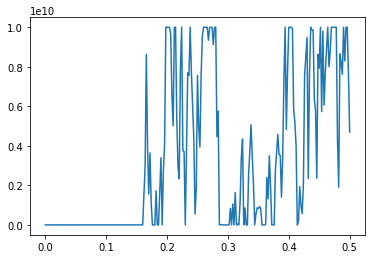

In [117]:
dt = T0/N
curve = np.zeros(N+1)
v_uni = vecteur_uni(d)
chi_mat = diag(chi)

I = np.zeros(d)
x = np.zeros(d)
y = np.zeros((d,d))
Z = np.random.standard_normal(N*d)
for i in range(N):
    print("i=",i)
    t = i * dt
    #construction de sigma
    H_tild = H_tilde(chi,delta,d)
    ft = f(t,chi,delta,d,init_forward,x,y)
    diag_sigmaf = [lmbda[k] * (a[k] + b[k]*ft[k]) for k in range(d)]
    sigma_f = diag(diag_sigmaf)
    Df = D(corr_mat)
    sigma_i = H_tild.dot(sigma_f.dot(np.transpose(Df)))
    print("sigma_f=",sigma_f)
    print("H_tilde=",H_tild)
    
    # incrément gaussien
    incr = math.sqrt(dt)*np.array([Z[i*d+j] for j in range(d)])

    I = I - x * dt
      
    x = lim_diffx(d,x + (y.dot(v_uni) - chi_mat.dot(x)) * dt + sigma_i.dot(incr),a,b)
            
    y = lim_diffy(d,y + (sigma_i.dot(np.transpose(sigma_i)) - chi_mat.dot(y) - y.dot(chi_mat)) * dt)
    print("x=",x,"y=",y)
    curve[i+1] = x[0]
    print()

absc = [j*dt for j in range(N+1)]
plt.plot(absc,curve)

**Remarques:** Les taux $f_i(t)$ semblent exploser en raison du terme $\big(x(t) + y(t) \ G(t,t+\delta_i)\big)$

 $y$ s'accroit avec la volatilité et inversement, ce qui crée un effet "boule de neige" jusqu'à ce qu'un élément de $y$ devienne $+ / - \infty$

-> Nécessité de borner $y$ ?

**Remarque 2:** Les diffusions sont très volatiles, c'est pourquoi la simulation explose dans quasiment tous les cas lorsque $\chi$ est proche de zéro. La simulation ne pose aucun problème lorsque les $\chi_i$ dépassent les 0.25 (pour $\delta = 6M,2Y$).

n= 0
ui= 0.10838273176531824 exp(ui)= 1.1144742084519832 xi= 0.1144742084519832
[[0. 0.]
 [0. 0.]]
ui= 0.06367292532365766 exp(ui)= 1.065743763953146 xi= 0.06574376395314596
[[0. 0.]
 [0. 0.]]
n= 1
ui= 0.11826287902237005 exp(ui)= 1.1255399533228845 xi= 0.12553995332288448
[[0.00305466 0.00181199]
 [0.00181199 0.00110959]]
ui= 0.06354807880767976 exp(ui)= 1.0656107178626344 xi= 0.0656107178626344
[[0.00305466 0.00181199]
 [0.00181199 0.00110959]]
n= 2
ui= 0.15125749213906636 exp(ui)= 1.1632961591369657 xi= 0.1632961591369657
[[0.0068088  0.0040182 ]
 [0.0040182  0.00244929]]
ui= 0.07718872640671781 exp(ui)= 1.080245928088276 xi= 0.08024592808827591
[[0.0068088  0.0040182 ]
 [0.0040182  0.00244929]]
n= 3
ui= 0.18634967617204282 exp(ui)= 1.2048434917861628 xi= 0.2048434917861628
[[0.01062613 0.00626211]
 [0.00626211 0.00381228]]
ui= 0.10499548121334733 exp(ui)= 1.1107055913027641 xi= 0.11070559130276414
[[0.01062613 0.00626211]
 [0.00626211 0.00381228]]
n= 4
ui= 0.17890550316250908 exp(u

n= 95
ui= -0.07587792957055883 exp(ui)= 0.926929350317343 xi= -0.07307064968265697
[[0.44776054 0.27249735]
 [0.27249735 0.17105586]]
ui= 0.05908936248468727 exp(ui)= 1.0608700384869842 xi= 0.060870038486984246
[[0.44776054 0.27249735]
 [0.27249735 0.17105586]]
n= 96
ui= -0.16383900779557733 exp(ui)= 0.8488786737289414 xi= -0.15112132627105856
[[0.45507758 0.27710265]
 [0.27710265 0.17403315]]
ui= 0.008125125449051668 exp(ui)= 1.0081582238630256 xi= 0.00815822386302556
[[0.45507758 0.27710265]
 [0.27710265 0.17403315]]
n= 97
ui= -0.07036171998373084 exp(ui)= 0.9320566154190586 xi= -0.0679433845809414
[[0.46195103 0.28146134]
 [0.28146134 0.17686874]]
ui= 0.04494252227600819 exp(ui)= 1.0459677383359396 xi= 0.04596773833593959
[[0.46195103 0.28146134]
 [0.28146134 0.17686874]]
n= 98
ui= 0.014542828050041687 exp(ui)= 1.0146490894628344 xi= 0.014649089462834386
[[0.46818874 0.28546118]
 [0.28546118 0.17949487]]
ui= 0.07465600021794366 exp(ui)= 1.0775134227405014 xi= 0.07751342274050144
[[0

ui= -10000000000.0 exp(ui)= 1e-16 xi= -0.9999999999999999
[[1.10622096 0.72574979]
 [0.72574979 0.48646746]]
n= 203
ui= -10000000000.0 exp(ui)= 1e-16 xi= -0.9999999999999999
[[1.11076348 0.72923312]
 [0.72923312 0.48908987]]
ui= -10000000000.0 exp(ui)= 1e-16 xi= -0.9999999999999999
[[1.11076348 0.72923312]
 [0.72923312 0.48908987]]
n= 204
ui= -10000000000.0 exp(ui)= 1e-16 xi= -0.9999999999999999
[[1.11536264 0.73275494]
 [0.73275494 0.49173902]]
ui= -10000000000.0 exp(ui)= 1e-16 xi= -0.9999999999999999
[[1.11536264 0.73275494]
 [0.73275494 0.49173902]]
n= 205
ui= -10000000000.0 exp(ui)= 1e-16 xi= -0.9999999999999999
[[1.12001939 0.73631591]
 [0.73631591 0.49441536]]
ui= -10000000000.0 exp(ui)= 1e-16 xi= -0.9999999999999999
[[1.12001939 0.73631591]
 [0.73631591 0.49441536]]
n= 206
ui= -10000000000.0 exp(ui)= 1e-16 xi= -0.9999999999999999
[[1.12473472 0.7399167 ]
 [0.7399167  0.49711935]]
ui= -10000000000.0 exp(ui)= 1e-16 xi= -0.9999999999999999
[[1.12473472 0.7399167 ]
 [0.7399167  0.49

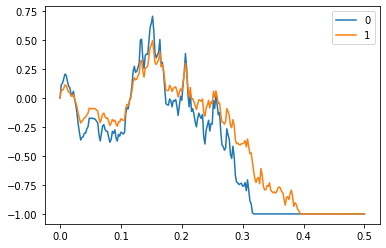

In [109]:
#Test log Euler
import matplotlib.pyplot as plt
T0 = 0.5
N = 250
dt = T0/N
curve = np.zeros((d,N+1))
v_uni = vecteur_uni(d)
chi_mat = diag(chi)
Df = D(corr_mat) #matrice de corrélation constante
I = np.zeros(d)
x = np.zeros(d)
u = np.array([np.log(a[i]/b[i]) for i in range(d)])
y = np.zeros((d,d))
Z = np.random.standard_normal(N*d)
absc = [j*dt for j in range(N+1)]


for n in range(N):
    t = n * dt

    #construction de sigma
    H_tild = H_tilde(chi,delta,d)
    ft = f(t,chi,delta,d,init_forward,x,y)
    diag_sigmaf = [lmbda[k] * (a[k] + b[k]*ft[k]) for k in range(d)]
    sigma_f = diag(diag_sigmaf)
    sigma_n = H_tild.dot(sigma_f.dot(np.transpose(Df)))
    # incrément brownien
    incr = math.sqrt(dt)*np.array([Z[n*d+j] for j in range(d)])

    I = I - x * dt
    print("n=",n)
    for i in range(d):
        temp = 1/(x[i]+a[i]/b[i])
        saut = temp * (y[i].dot(v_uni) - chi[i]*x[i] - 0.5 * temp * sigma_n[i].dot(np.transpose(sigma_n[i]))) * dt + temp * sigma_n[i].dot(incr)
        sign = -1 + 2*(u[i] + saut>0)
        if(np.absolute(u[i] + saut) > 1e10):
            u[i] = sign * 1e10
        else:
            u[i] = u[i] + saut
        exp_u = np.exp(u[i])
        if(exp_u < 1e-16):
            exp_u = 1e-16  #Borné à 1e-16 car si plus petit, exp_u - ai/bi = -ai/bi et division par zero
        x[i] = exp_u - a[i]/b[i]
        curve[i][n+1] = x[i]
        print("ui=",u[i],"exp(ui)=",exp_u,"xi=",x[i])
        print(y)
        
    y = lim_diffy(d,y + (sigma_n.dot(np.transpose(sigma_n)) - chi_mat.dot(y) - y.dot(chi_mat)) * dt)
    #y =y + (sigma_n.dot(np.transpose(sigma_n)) - chi_mat.dot(y) - y.dot(chi_mat)) * dt
    
for index in range(d):
    plt.plot(absc,curve[index],label=str(index))
plt.legend()
plt.show()

In [118]:
I,X,Y = simul_multi(M,N,T0,d,chi,delta,init_forward,corr_mat,lmbda,a,b)
"""try:
    I,X,Y = log_Euler(M,N,T0,d,chi,delta,init_forward,corr_mat,lmbda,a,b)
except RuntimeWarning:
    print("Borne inférieure touchée")
    raise"""

'try:\n    I,X,Y = log_Euler(M,N,T0,d,chi,delta,init_forward,corr_mat,lmbda,a,b)\nexcept RuntimeWarning:\n    print("Borne inférieure touchée")\n    raise'

In [119]:
print("X=",X)
print("Y=",Y)
print("I=",I)

X= [[        nan         nan]
 [        nan         nan]
 [-0.59435763 -0.66926823]
 ...
 [-0.92443558 -0.74842961]
 [        nan         nan]
 [        nan         nan]]
Y= [[[       nan        nan]
  [       nan        nan]]

 [[       nan        nan]
  [       nan        nan]]

 [[0.55783385 0.44906649]
  [0.44906649 0.36332713]]

 ...

 [[0.15587262 0.12528321]
  [0.12528321 0.10137864]]

 [[       nan        nan]
  [       nan        nan]]

 [[       nan        nan]
  [       nan        nan]]]
I= [[       nan        nan]
 [       nan        nan]
 [0.35493962 0.32443207]
 ...
 [0.31821154 0.26387605]
 [       nan        nan]
 [       nan        nan]]


In [120]:
y = Y[0]
x = X[0]
payoff_swaption_multi(d,maturities,bonds,x,y,chi,K)

0

In [121]:
#Simulation Prix chi= 0.015, 0.15
sim = I,X,Y
prix = swaption_MC_multi(d,M,sim,K,chi,bonds,maturities,True,True)
print("Swaption Price:",prix)

Execution time:  0.9284915924072266 sec
Variance: 0.5989368202957044
Nb. Occurences Supprimées: 95419
Swaption Price: 0.8663199264989534


In [122]:
#Simulation Prix chi= 0.5,0.5
chi = [0.5,0.5]
sim = simul_multi(M,N,T0,d,chi,delta,init_forward,corr_mat,lmbda,a,b)
prix = swaption_MC_multi(d,M,sim,K,chi,bonds,maturities,True,True)
print("Swaption Price:",prix)

Execution time:  11.056241512298584 sec
Variance: 0.12417327852702459
Nb. Occurences Supprimées: 3072
Swaption Price: 0.5926769262195422


In [123]:
#Simulation Prix chi= 1,1
chi = [1,1]
sim = simul_multi(M,N,T0,d,chi,delta,init_forward,corr_mat,lmbda,a,b)
prix = swaption_MC_multi(d,M,sim,K,chi,bonds,maturities,True,True)
print("Swaption Price:",prix)

Execution time:  12.116346836090088 sec
Variance: 0.049759744267732185
Nb. Occurences Supprimées: 0
Swaption Price: 0.22830081197189592


| $\chi$ | Occurences supprimées /100 000|
|--------------|-----------|
| (0.015,0.15)| 95 419   | 
| (0.5,0.5)  |  3 072   | 
| (1,1)      | 0   | 

In [126]:
# test 1d 
d = 1
corr_mat = np.eye(d)
chi = [0.015]
delta = [0.5]
a = [1]
b = [1]
lmbda = [1]
init_forward = [0.05]
sim = simul_multi(M,N,T0,d,chi,delta,init_forward,corr_mat,lmbda,a,b)
prix = swaption_MC_multi(d,M,sim,K,chi,bonds,maturities,True,True)
print("Swaption Price:",prix)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in subtract
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in add


Execution time:  10.239793539047241 sec
Variance: 0.10481588985835377
Nb. Occurences Supprimées: 32
Swaption Price: 0.6798376496838504


-> le modèle en une dimension est différent du modèle multidimensionnel avec d=1

In [28]:
#Temps d'execution
for m in [1000,10000,100000]:
    t_start = time()
    sim = simul_multi(m,N,T0,d,chi,delta,init_forward,corr_mat,lmbda,a,b)
    prix = swaption_MC_multi(d,m,sim,K,chi,bonds,maturities,True,True)
    t_finish = time()
    print("Temps pour M= " +str(m) + ":",t_finish-t_start, "Prix = ",prix)
    print()

Execution time:  0.08477306365966797 sec
Variance: 0.2092476441811244
Nb. Occurences Supprimées: 388
Temps pour M= 1000: 13.082932233810425 Prix =  0.8656633723775358

Execution time:  0.699671745300293 sec
Variance: 0.2075847162060359
Nb. Occurences Supprimées: 3942
Temps pour M= 10000: 131.47392773628235 Prix =  0.8574484595446707

Execution time:  7.446349143981934 sec
Variance: 0.20391367112951608
Nb. Occurences Supprimées: 39703
Temps pour M= 100000: 1328.9626948833466 Prix =  0.8634853909845808



In [81]:
# Pricing log-Euler
sim = log_Euler(M,N,T0,d,chi,delta,init_forward,corr_mat,lmbda,a,b)
prix = swaption_MC_multi(d,M,sim,K,chi,bonds,maturities,True,True)
print("Swaption Price (log-Euler):",prix)
#Pricing Euler
sim = simul_multi(1000,N,T0,d,chi,delta,init_forward,corr_mat,lmbda,a,b)
prix = swaption_MC_multi(d,1000,sim,K,chi,bonds,maturities,True,True)
print("Swaption Price (Euler):",prix)

Execution time:  0.08178114891052246 sec
Variance: 0.20273649401433824
Nb. Occurences Supprimées: 399
Swaption Price (Euler): 0.8583562766586068


In [ ]:
#chi = 1,1
chi = [1,1]
for m in [1000,10000,100000]:
    t_start = time()
    sim = simul_multi(m,N,T0,d,chi,delta,init_forward,corr_mat,lmbda,a,b)
    prix = swaption_MC_multi(d,m,sim,K,chi,bonds,maturities,True,True)
    t_finish = time()
    print("Temps pour M= " +str(m) + ":",t_finish-t_start, "Prix = ",prix)
    print()

| M | Temps (sec) | Variance |
|--------------|-----------|-----------|
| 1000         | 8     | 0.000139   |
| 10 000       |  81    | 0.000135    |
| 100 000      | 795    | 0.000134  |

Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0


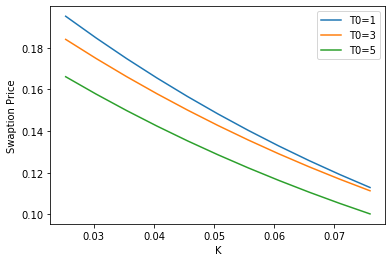

In [31]:
T0s = [1,3,5]
for T0 in T0s:
    maturities = np.arange(T0,T0+5.5,0.5) #5Y tenor
    bonds = [np.exp(-0.05*m) for m in maturities]
    S0 = S(0,np.zeros(d),np.zeros((d,d)),maturities,bonds,1,chi,d)
    strikes = [0.1*k*S0 for k in range(5,16)]
    sim = simul_multi(M,N,T0,d,chi,delta,init_forward,corr_mat,lmbda,a,b)
    Prices = [swaption_MC_multi(d,M,sim,k,chi,bonds,maturities,False,False) for k in strikes]
    plt.plot(strikes,Prices,label="T0=" +str(T0))

plt.legend()
plt.xlabel('K')
plt.ylabel('Swaption Price')
plt.show()

## Comparaison modele 1d et Multi d=1

In [27]:
#import Prices from 1d model
import csv
Price1d = []
with open('./Price1d.csv') as my_file:
    my_file_reader = csv.reader(my_file, delimiter=',', quotechar='"')
    for x in my_file_reader:
        if (x != []):
            Price1d.append([float(y) for y in x])
Price1d

[[0.22964132773215656,
  0.22153169054125066,
  0.21385537610372207,
  0.2065875859006012,
  0.19970629446607477,
  0.19318268045746492,
  0.18700346498528916,
  0.18114091604957755,
  0.17556228877379082,
  0.17025567578593576,
  0.16520174494291587],
 [0.2094603988835766,
  0.20226683006837815,
  0.19545795094085616,
  0.18900321399556153,
  0.18289761364851734,
  0.17711643550497996,
  0.17163948666689416,
  0.1664303094688678,
  0.16147035966157194,
  0.1567570511343226,
  0.15225885147353022],
 [0.1904983994731586,
  0.18392525386139866,
  0.17770250954745367,
  0.17180437288394193,
  0.16623523723930506,
  0.16097953173419718,
  0.15599716154257806,
  0.1512636937370016,
  0.14675976391582757,
  0.14246130653975989,
  0.13836167819576356]]

Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0
Nb. Occurences Supprimées: 0


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in add
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in subtract


Nb. Occurences Supprimées: 2
Nb. Occurences Supprimées: 2
Nb. Occurences Supprimées: 2
Nb. Occurences Supprimées: 2
Nb. Occurences Supprimées: 2
Nb. Occurences Supprimées: 2
Nb. Occurences Supprimées: 2
Nb. Occurences Supprimées: 2
Nb. Occurences Supprimées: 2
Nb. Occurences Supprimées: 2
Nb. Occurences Supprimées: 2


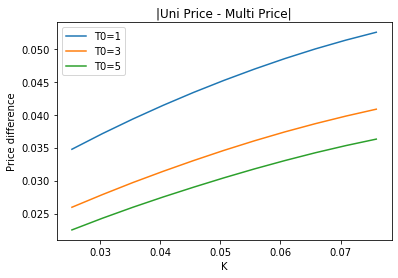

In [30]:
#Plot the difference between Prices from both models
i = 0
T0s = [1,3,5]
for T0 in T0s:
    maturities = np.arange(T0,T0+5.5,0.5) #5Y tenor
    bonds = [np.exp(-0.05*m) for m in maturities]
    S0 = S(0,np.zeros(d),np.zeros((d,d)),maturities,bonds,1,chi,d)
    strikes = [0.1*k*S0 for k in range(5,16)]
    sim = simul_multi(M,N,T0,d,chi,delta,init_forward,corr_mat,lmbda,a,b)
    Prices1 = [swaption_MC_multi(d,M,sim,k,chi,bonds,maturities,False,False) for k in strikes]
    Prices2 = Price1d[i]
    i+=1
    diff = np.absolute(np.array(Prices1) - np.array(Prices2))
    plt.plot(strikes,diff,label="T0=" +str(T0))

plt.legend()
plt.xlabel('K')
plt.ylabel('Price difference')
plt.title("|Uni Price - Multi Price|")
plt.show()

## Approximation displaced log-normale

In [15]:
#volatilité sigma_x(t,x,y) 
#ajout de dictionnaire car appels récurrents dans x_bar et y_bar

#dico_sigma = {}
def sigma_x(t,chi,delta,d,init_forward,lmbda,a,b,x,y):
    #arg = (s,tuple(chi),tuple(delta),d,tuple(init_forward),tuple(lmbda),tuple(a),tuple(b),tuple(x),tuple(y))
    H_tild = H_tilde(chi,delta,d)
    ft = f(t,chi,delta,d,init_forward,x,y)
    diag_sigmaf = [lmbda[k] * (a[k] + b[k]*ft[k]) for k in range(d)]
    sigma_f = diag(diag_sigmaf) 
    sigma_x = H_tild.dot(sigma_f.dot(np.transpose(Df)))
    return sigma_x
    
def cx(t,chi,delta,d,init_forward,lmbda,a,b,x,y):
    sigma_xt = sigma_x(t,chi,delta,d,init_forward,lmbda,a,b,x,y)
    return np.transpose(sigma_xt).dot(sigma_xt)


#dictionnary to stock computed values in memory
dico_y_bar = {}
    
#auxiliary fonction s -> H(s)^-1 * sigma_x(s,0,0) ^T * sigma_x(s,0,0) * H(s)^-1
def aux_y_bar(s,chi,delta,d,init_forward,lmbda,a,b):
    arg = (s,tuple(chi),tuple(delta),d,tuple(init_forward),tuple(lmbda),tuple(a),tuple(b))
    if (arg in dico_y_bar):
        return dico_y_bar[arg]
    else:
        Hs_inv = np.linalg.inv(H(s,chi,d))
        c = cx(s,chi,delta,d,init_forward,lmbda,a,b,np.zeros(d),np.zeros((d,d)))
        resu = Hs_inv.dot(c)
        return resu.dot(Hs_inv)
    

def y_bar(t,chi,delta,d,init_forward,lmbda,a,b):
    Ht = H(t,chi,d)
    resu = np.zeros((d,d))
    for i in range(d):
        for j in range(d):
            resu[i][j] = integrate.quad(lambda s: aux_y_bar(s,chi,delta,d,init_forward,lmbda,a,b)[i][j],0,t)[0]
    return Ht.dot(resu.dot(Ht))
    

In [23]:
Df = D(corr_mat)
chi = [1,1]
a = [1,1]
b= [1,1]
y_bar(0.5,chi,delta,d,init_forward,lmbda,a,b)

array([[0.13457217, 0.13457217],
       [0.13457217, 0.13457217]])

$$\bar{x}(t) = H(t) \int_{0}^{t} H(s)^{-1} \big( \bar{y}(s) \mathbb{1} - \sigma_x(s,0,0)^\top \sigma_x(s,0,0) \frac{1}{A(0)} \sum_{n=0}^{N-1} \tau_n P(0,T_{n+1})G(s,T_{n+1})\big) \ \mathrm{d}s$$

In [24]:
def aux_x_bar(s,chi,delta,d,init_forward,lmbda,a,b,maturities,bonds):
    N = len(maturities)
    Hs_inv = np.linalg.inv(H(s,chi,d))
    v_uni = vecteur_uni(d)
    y_s_bar = y_bar(s,chi,delta,d,init_forward,lmbda,a,b).dot(v_uni)
    c = cx(s,chi,delta,d,init_forward,lmbda,a,b,np.zeros(d),np.zeros((d,d)))
    GA = sum([(maturities[n+1]-maturities[n])* bonds[n+1]* G(s,maturities[n+1],chi,d) for n in range(0,N-1)]) / A(0,np.zeros(d),np.zeros((d,d)),maturities,bonds,1,chi,d)
    return Hs_inv.dot(y_s_bar - c.dot(GA))
    
def x_bar(t,chi,delta,d,init_forward,lmbda,a,b,maturities,bonds):
    Ht = H(t,chi,d)
    resu = np.zeros(d)
    for i in range(d):
        resu[i] = integrate.quad(lambda s: aux_x_bar(s,chi,delta,d,init_forward,lmbda,a,b,maturities,bonds)[i],0,t)[0]
    return Ht.dot(resu)

In [25]:
x_bar(0.5,chi,delta,d,init_forward,lmbda,a,b,maturities,bonds)

array([-0.22476724, -0.22476724])

In [26]:
sum([(maturities[n+1]-maturities[n])* bonds[n+1]* G(0.5,maturities[n+1],chi,d) for n in range(0,len(maturities)-1)]) / A(0,np.zeros(d),np.zeros((d,d)),maturities,bonds,1,chi,d)

array([0.83511785, 0.83511785])